In [8]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 48.7 MB/s eta 0:00:00


###Homogeneous graph tasks using deepsnap

In [9]:
'''Node classification Transductive setting'''
import torch
import warnings
import networkx as nx
import matplotlib.pyplot as plt

from copy import deepcopy
from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch.utils.data import dataloader

#disabling DeepSNAP warnings
warnings.filterwarnings("ignore")

graph has 34 nodes and 78 edge 


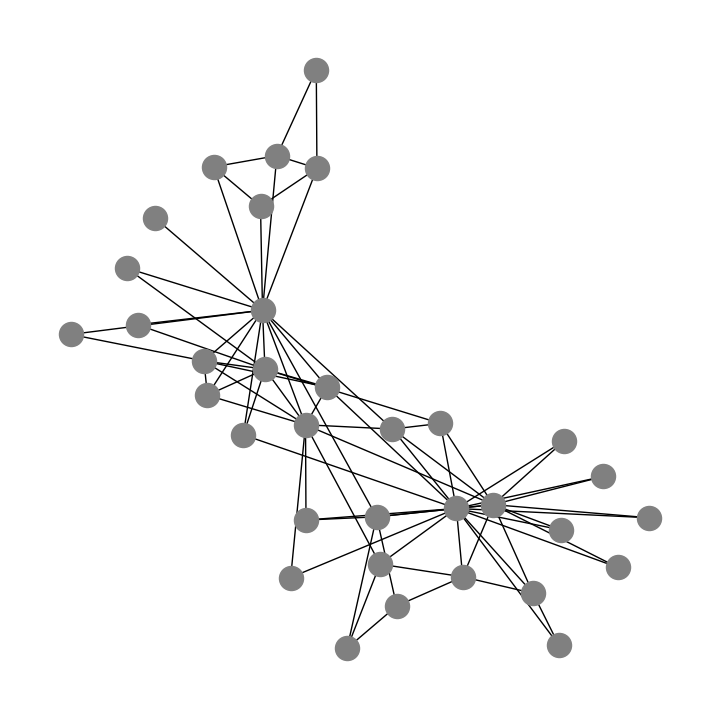

In [ ]:
G = nx.karate_club_graph()
print(f"graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edge ")
pos = nx.spring_layout(G, seed=1)
plt.figure(figsize=(7, 7))
nx.draw(G, pos=pos, cmap=plt.get_cmap("coolwarm"), node_color="grey")
plt.show()

In [ ]:
#creating a visualization function to view node and labels
def visualize(colors, title=None):
    plt.figure(figsize=(8, 8))
    if title is not None:
        plt.title(title, fontsize=20)
    nodes = nx.draw_networkx_nodes(H, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color=colors)
    nodes.set_edgecolor('black')
    edges = nx.draw_networkx_edges(H, pos=pos)
    plt.scatter([],[], c='blue', label='Mr. Hi', edgecolors="black", s=140)
    plt.scatter([],[], c='red', label='Officer', edgecolors="black", s=140)
    if "grey" in colors:
        plt.scatter([],[], c='grey', label='N/A', edgecolors="black", s=140)
    plt.legend(prop={'size': 15}, handletextpad=0)
    plt.show()

In [ ]:
H = deepcopy(G)
node_color = {}
community_map = {}
for node in H.nodes(data=True):
    if node[1]["club"] == "Mr. Hi":
        node_color[node[0]] = "blue"
        community_map[node[0]] = 0
    else:
        node_color[node[0]] = "red"
        community_map[node[0]] = 1
nx.classes.function.set_node_attributes(H, community_map, name='node_label')
nx.classes.function.set_node_attributes(H, node_color, name='color')
colors = nx.get_node_attributes(H, 'color').values()
visualize(colors)

In [ ]:
# Create the DeepSNAP dataset by setting the task to node (node classification)
dg_dataset = GraphDataset([H], task="node")

# Random split to train, validation and test sets
dataset_train, dataset_val, dataset_test = dg_dataset.split(transductive=True, split_ratio=[0.4, 0.3, 0.3]) #full graph with different node label and node label idx
#each split can be passed into a dataloader object
set_name = ["Train", "Validation", "Test"]
for i, dataset in enumerate([dataset_train, dataset_val, dataset_test]):
    node_set = set()
    colors = []
    data = dataset[0]
    for node in data.node_label_index:
        node_set.add(node.item())
    for node in H.nodes():
        if node not in node_set:
            colors.append("grey")
        else:
            colors.append(node_color[node])
    visualize(colors, title=set_name[i])

In [10]:
#simple GNN for node classification
import copy
import torch
import torch.nn as nn
import networkx as nx
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim

from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch_geometric.datasets import Planetoid
from torch.utils.data import DataLoader
from torch_geometric.nn import SAGEConv

In [ ]:
class GNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, args):
        super(GNN, self).__init__()
        self.num_layers = args["num_layers"]

        self.convs = nn.ModuleList()
        self.convs.append(SAGEConv(input_size, hidden_size))
        for l in range(self.num_layers - 1):
            self.convs.append(SAGEConv(hidden_size, hidden_size))
        self.post_mp = nn.Linear(hidden_size, output_size)

    def forward(self, data):
        x, edge_index, batch = data.node_feature, data.edge_index, data.batch

        for i in range(len(self.convs) - 1):
            x = self.convs[i](x, edge_index)
            x = F.leaky_relu(x)
        x = self.convs[-1](x, edge_index)
        x = F.log_softmax(x, dim=1)
        return x

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [ ]:
def train(train_loader, val_loader, test_loader, args, num_node_features, num_classes,
          device="cpu"):
    model = GNN(num_node_features, args['hidden_size'], num_classes, args).to(device)
    print(model)
    optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=5e-4)

    for epoch in range(args['epochs']):
        total_loss = 0
        model.train()
        for batch in train_loader:
            batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            label = batch.node_label
            loss = model.loss(pred[batch.node_label_index], label)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        train_acc = test(train_loader, model, device)
        val_acc = test(val_loader, model, device)
        test_acc = test(test_loader, model, device)
        print(f"Epoch{epoch+1} Train: {train_acc:.4f}, Val: {val_acc:.4}, Test:{test_acc:.4f}")

@torch.no_grad()
def test(loader, model, device="cpu"):
  model.eval()
  for batch in loader:
    batch.to(model.device)
    logits = model(batch)
    pred = logits[batch.node_label_index].max(1)[1]
    acc = pred.eq(batch.node_label).sum().item()
    total = batch.node_label_index.shape[0]
  return acc / total


In [ ]:
#training

args = {
    "device": 'cuda' if torch.cuda.is_available() else "cpu",
    "hidden_size": 128,
    "epochs" : 100,
    "lr": 0.01,
    "num_layers": 2,
    "dataset": "Cora",
}

#Working with PyG
pyg_dataset = Planetoid('./tmp/cora', args["dataset"])
graphs_train, graph_val, graphs_test = GraphDataset.pyg_to_graphs(pyg_dataset, fixe_split=True)

dataset_train, dataset_val, dataset_test = GraphDataset(graphs_train, task="node"), GraphDataset(graphs_val, task="node"),
                                            GraphDataset(graph_test, task="node")

train_loader = DataLoader(dataset_train, collate_fn=Batch.collate(), batch_size=1)
val_loader = DataLoader(dataset_val, collate_fn=Batch.collate(), batch_size=1)
test_loader = DataLoader(dataset_test, collate_fn=Batch.collate(), batch_size=1)

num_classes, num_node_features = dataset_train.num_node_labels, dataset_train.num_node_features

train(train_loader, val_loader, test_loader, args, num_node_features, num_classes, args['device'])


###Link Prediction

* Transductive Link Prediction means
we'll have message passing edges and supervision edges.

In [ ]:
from pylab import *

The graph has 34 nodes and 156 edges


<function matplotlib.pyplot.show(close=None, block=None)>

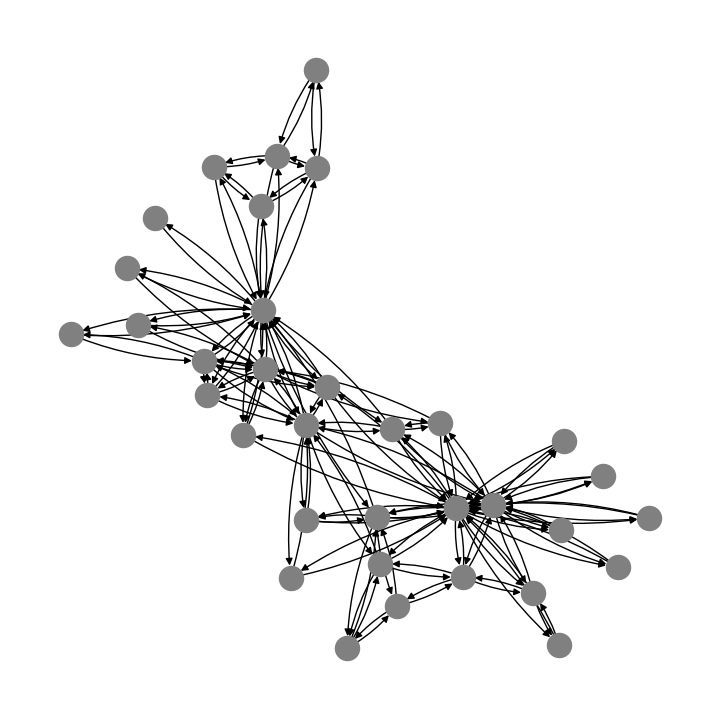

In [ ]:
G = nx.karate_club_graph().to_directed()
print(f'The graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges')
pos = nx.spring_layout(G, seed=1)
plt.figure(figsize=(7, 7))
nx.draw(G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color="grey", connectionstyle="arc3, rad=0.1")
plt.show

DeepSNAP Link prediction modes
* egde_train_mode = "all"
* edge_train_mode = "Disjoint"

negative edges will have label 0 and supervision edge label 1. all other edge labels will be offsetted by one.

* At training time: the training supervision edges are same with the training message passing edges.
* At validation time: the message passing edges are the training message passing edges and training supervision edges (still the training message passing edges in this case). The validation supervision edges are disjoint with training supervision edges.
* At test time: the message passing edges are the union of training message passing edges, training supervision edges, and validation supervision edges. The test supervision edges are disjoint with training supervision edges and validation supervision edges.

Original DeepSNAP dataset has 156
Train set has 124 message passing edges and 124 supervision edges
Val set has 124 message passing edges and 15 supervision edges
Test set has 124 message passing edges and 17 supervision edges


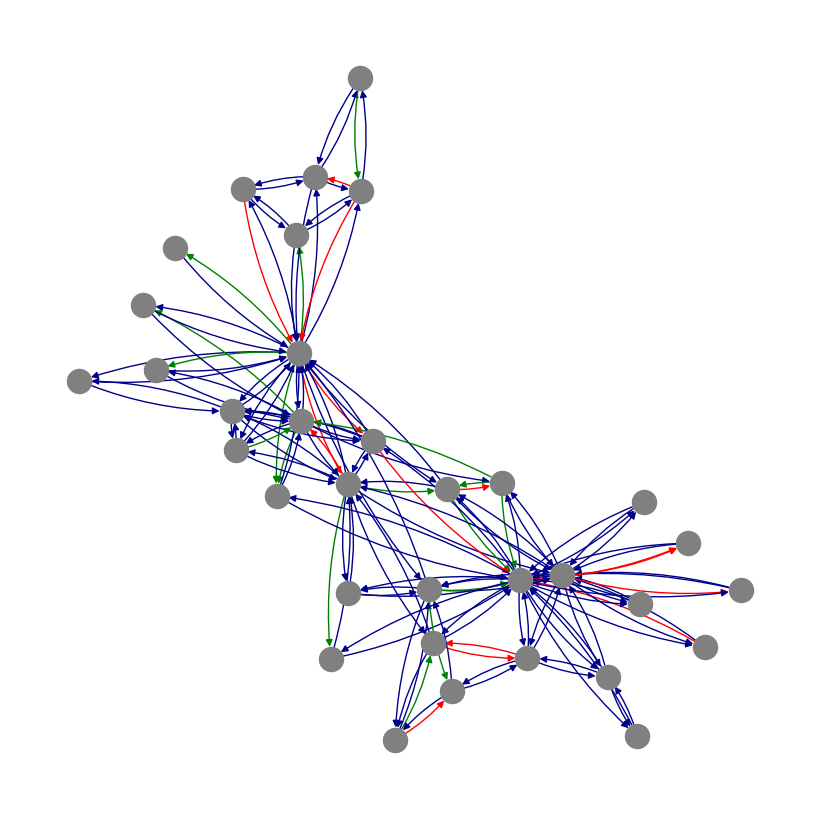

In [ ]:
#DeepSNAP link prediction, using edge_train_mode='all'
task = "link_pred"
dg = Graph(G)
dataset = GraphDataset([dg], task=task, edge_train_mode="all")
print(f"Original DeepSNAP dataset has {dataset.num_edges[0]}")

#split the dataset
dataset_train, dataset_val, dataset_test = dataset.split(
    transductive=True, split_ratio=[0.8, 0.1, 0.1]
)

#supervision edges
num_train_edges = dataset_train[0].edge_label_index.shape[1]  #2, num
num_val_edges = dataset_val[0].edge_label_index.shape[1]
num_test_edges = dataset_test[0].edge_label_index.shape[1]

#message_passing edges
num_train_edges_m = dataset_train[0].edge_index.shape[1]
num_val_edges_m = dataset_val[0].edge_index.shape[1]
num_test_edges_m = dataset_test[0].edge_index.shape[1]

print(f"Train set has {num_train_edges_m} message passing edges and {num_train_edges // 2} supervision edges")
print(f"Val set has {num_val_edges_m} message passing edges and {num_val_edges // 2} supervision edges")
print(f"Test set has {num_val_edges_m} message passing edges and {num_test_edges // 2} supervision edges")

#print
edge_color = {}

for i in range(num_train_edges // 2):
  edge = dataset_train[0].edge_label_index[:, i]
  edge = (edge[0].item(), edge[1].item())
  edge_color[edge] = "darkblue"
for i in range(num_val_edges // 2):
  edge = dataset_val[0].edge_label_index[:, i]
  edge = (edge[0].item(), edge[1].item())
  edge_color[edge] = "red"
for i in range(num_test_edges // 2):
  edge = dataset_test[0].edge_label_index[:, i]
  edge = (edge[0].item(), edge[1].item())
  edge_color[edge] = "green"


H = deepcopy(G)

nx.classes.function.set_edge_attributes(H, edge_color, name="color")
colors = nx.get_edge_attributes(H, "color").values()  #stored as dict
plt.figure(figsize=(8,8))
nx.draw(H, pos=pos, cmap=plt.get_cmap("coolwarm"), node_color="grey",
        edge_color=colors, connectionstyle="arc3, rad=0.1")


###Disjoint Mode

* At training time: the training supervision edges are disjoint with the training message passing edges.
* At validation time: the message passing edges are the union of training message passing edges and training supervision edges. Notice that the validation supervision edges are disjoint with training supervision edges.
* At test time: the message passing edges are the training message passing edges, training supervision edges, and validation supervision edges. The test supervision edges are disjoint with training supervision edges and validation supervision edges.

Original DeepSNAP dataset has 156
Train set has 99 message passing edges and 25 supervision edges
Val set has 124 message passing edges and 15 supervision edges
Test set has 124 message passing edges and 17 supervision edges


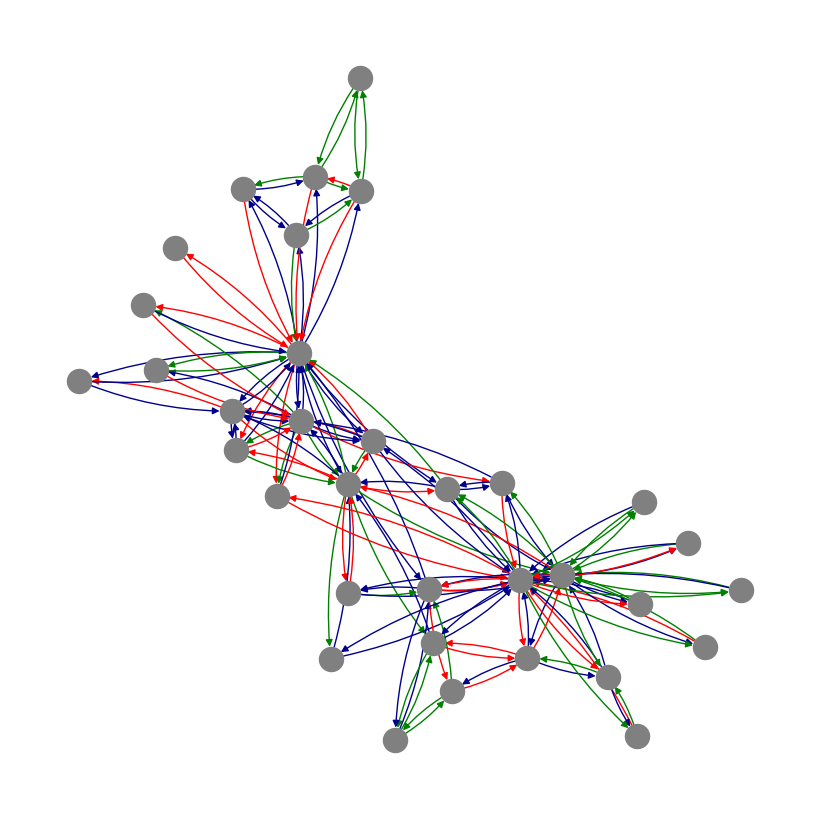

In [ ]:
# Disjoint mode  (difference is in train message and train supervision edges)
task = "link_pred"
dg = Graph(G)
dataset = GraphDataset([dg], task=task, edge_train_mode="disjoint")
print(f"Original DeepSNAP dataset has {dataset.num_edges[0]}")

#split the dataset
dataset_train, dataset_val, dataset_test = dataset.split(
    transductive=True, split_ratio=[0.8, 0.1, 0.1]
)

#supervision edges
num_train_edges = dataset_train[0].edge_label_index.shape[1]  #2, num
num_val_edges = dataset_val[0].edge_label_index.shape[1]
num_test_edges = dataset_test[0].edge_label_index.shape[1]

#message_passing edges
num_train_edges_m = dataset_train[0].edge_index.shape[1]
num_val_edges_m = dataset_val[0].edge_index.shape[1]
num_test_edges_m = dataset_test[0].edge_index.shape[1]

print(f"Train set has {num_train_edges_m} message passing edges and {num_train_edges // 2} supervision edges")
print(f"Val set has {num_val_edges_m} message passing edges and {num_val_edges // 2} supervision edges")
print(f"Test set has {num_val_edges_m} message passing edges and {num_test_edges // 2} supervision edges")

#print
edge_color = {}

for i in range(num_train_edges // 2):
  edge = dataset_train[0].edge_label_index[:, i]
  edge = (edge[0].item(), edge[1].item())
  edge_color[edge] = "darkblue"
for i in range(num_val_edges // 2):
  edge = dataset_val[0].edge_label_index[:, i]
  edge = (edge[0].item(), edge[1].item())
  edge_color[edge] = "red"
for i in range(num_test_edges // 2):
  edge = dataset_test[0].edge_label_index[:, i]
  edge = (edge[0].item(), edge[1].item())
  edge_color[edge] = "green"


H = deepcopy(G)

nx.classes.function.set_edge_attributes(H, edge_color, name="color")
colors = nx.get_edge_attributes(H, "color").values()  #stored as dict
plt.figure(figsize=(8,8))
nx.draw(H, pos=pos, cmap=plt.get_cmap("coolwarm"), node_color="grey",
        edge_color=colors, connectionstyle="arc3, rad=0.1")

In [ ]:
#Inductive Link Prediction Split (understand split)
dgs = [deepcopy(dg) for i in range(10)]
dataset = GraphDataset(dgs, task=task)

#split dataset
dataset_train, dataset_val, dataset_test = dataset.split(
    transductive=False, split_ratio=[0.8, 0.1, 0.1]
)

print("There are {} graphs in training set".format(len(dataset_train)))
print("There are {} graphs in validation set".format(len(dataset_val)))
print("There are {} graphs in test set".format(len(dataset_test)))

There are 8 graphs in training set
There are 1 graphs in validation set
There are 1 graphs in test set


Negative sampling is done automatically by deepsnap. negative edges are resampled for every new batch.



In [ ]:
#setting negative sampling ratios
ratio = 1   #equal negative and positive edges
dataset = GraphDataset([dg], task=task, edge_negative_sampling_ratio=ratio) #1 is the default
dataset_train, dataset_val, dataset_test = dataset.split(
    transductive=True, split_ratio=[0.8,0.1,0.1]
)
#dataset[0].edge_label is a row tensor
train_num_negative = dataset_train[0].edge_label.shape[0] - torch.count_nonzero(dataset_train[0].edge_label)
print(f'sampling ratio 1 has {train_num_negative} negative edges')

ratio = 2   #positive * 2 = negative count
dataset = GraphDataset([dg], task=task, edge_negative_sampling_ratio=ratio) #1 is the default
dataset_train, dataset_val, dataset_test = dataset.split(
    transductive=True, split_ratio=[0.8,0.1,0.1]
)
#dataset[0].edge_label is a row tensor
train_num_negative = dataset_train[0].edge_label.shape[0] - torch.count_nonzero(dataset_train[0].edge_label)
print(f'sampling ratio 2 has {train_num_negative} negative edges')


sampling ratio 1 has 124 negative edges
sampling ratio 2 has 248 negative edges


In [ ]:
#By default the val and test loaders negative edges won't be resampled
import torch
from torch.utils.data import DataLoader
dataset = GraphDataset([dg], task=task)
dataset_train, dataset_val, dataset_test = dataset.split(
    transductive=True, split_ratio=[0.8,0.1,0.1]
)
dataloaders= {
    "train": DataLoader(
        dataset_train, collate_fn=Batch.collate([]), shuffle=True
    ),
    "val": DataLoader(dataset_val, collate_fn=Batch.collate([]), shuffle=True),
    "test": DataLoader(dataset_test, collate_fn=Batch.collate([]), shuffle=True)
}

neg_edge_1 = None
for batch in dataloaders['train']:
  num_edges = batch.edge_label_index.shape[1] // 2   #supervision edge
  neg_edges_1 = batch.edge_label_index[:, num_edges:] #negative edges are half
  break
for batch in dataloaders['train']: #2nd iter
  num_edges = batch.edge_label_index.shape[1] // 2
  neg_edges_2 = batch.edge_label_index[:, num_edges:]
  break
print(f"1st and 2nd iteration negatives are same: {torch.equal(neg_edges_1, neg_edges_2)}")

# For validation
neg_edges_1 = None
for batch in dataloaders['val']:
  num_edges = batch.edge_label_index.shape[1] // 2
  neg_edges_1 = batch.edge_label_index[:, num_edges:]
  break
neg_edges_2 = None
for batch in dataloaders['val']:
  num_edges = batch.edge_label_index.shape[1] // 2
  neg_edges_2 = batch.edge_label_index[:, num_edges:]
  break

print("1st iteration and 2nd iteration validation negative edges are equal -> {}".format(
    torch.equal(neg_edges_1, neg_edges_2)
))


1st and 2nd iteration negatives are same: False
1st iteration and 2nd iteration validation negative edges are equal -> True


In [ ]:
print(dataset_train[0].edge_index.shape) #actual edges
print(dataset_train[0].edge_label_index.shape) #appended with negative edges for supervision
print(dataset_train[0].edge_label.shape)    #the label of the supervison edges

torch.Size([2, 124])
torch.Size([2, 248])
torch.Size([248])


In [ ]:
# We can adjust the number of messge passing and supervision edges in disjoint mode.
mode = "disjoint"
ratio = 0.5
dataset = GraphDataset([dg], task=task, edge_train_mode=mode, edge_message_ratio=ratio)
dataset_train, dataset_val, dataset_test = dataset.split(
    transductive=True, split_ratio=[0.8,0.1,0.1]
)
num_message_edges = dataset_train[0].edge_index.shape[1]
num_supervision_edges = dataset_train[0].edge_label_index.shape[1] // 2
print("There are {} message passing edges in training set when sampling ratio is {}".format(
    num_message_edges, ratio))
print("There are {} supervision edges in training set when sampling ratio is {}".format(
    num_supervision_edges, ratio))

ratio = 0.8
dataset = GraphDataset([dg], task=task, edge_train_mode=mode, edge_message_ratio=ratio)
dataset_train, dataset_val, dataset_test = dataset.split(
            transductive=True, split_ratio=[0.8, 0.1, 0.1])
num_message_edges = dataset_train[0].edge_index.shape[1]
num_supervision_edges = dataset_train[0].edge_label.shape[0] // 2
print("There are {} message passing edges in training set when sampling ratio is {}".format(
    num_message_edges, ratio))
print("There are {} supervision edges in training set when sampling ratio is {}".format(
    num_supervision_edges, ratio))


There are 62 message passing edges in training set when sampling ratio is 0.5
There are 62 supervision edges in training set when sampling ratio is 0.5
There are 99 message passing edges in training set when sampling ratio is 0.8
There are 25 supervision edges in training set when sampling ratio is 0.8


In [ ]:
num_edges = dataset_train[0].edge_label_index.shape[1] // 2
neg_edges_2 = dataset_train[0].edge_label_index[:, num_edges:].shape[1]
print(f"{neg_edges_2} negative edges means that positive and negative supervision edges are equal")

25 negative edges means that positive and negative supervision edges are equal


###Link Prediction
using the Cora Data

In [11]:
from sklearn.metrics import roc_auc_score
from torch_geometric.datasets import Planetoid, TUDataset

#others have been imported during node classification

In [ ]:
class LinkPredModel(nn.Module):
  def __init__(self, input_size, hidden_size):
    super().__init__()

    self.conv1 = SAGEConv(input_size, hidden_size)
    self.conv2 = SAGEConv(hidden_size, hidden_size)
    self.bn1 = nn.BatchNorm1d(hidden_size)
    self.bn2 = nn.BatchNorm1d(hidden_size)
    self.loss_fn = nn.BCEwithLogitsLoss()

  def forward(self, batch):
    x, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index

    x = self.conv1(x, edge_index)
    x = self.bn1(x)
    x = F.leaky_relu(x)
    x = self.conv2(x, edge_index)
    x = self.bn2(x)

    node_first = torch.index_select(x, 0, edge_label_index[0, :].long())  #indexes out of x, zeroth dim
    node_second = torch.index_select(x, 0, edge_label_index[1].long())  #we can index this way too
    pred = torch.sum(node_first * node_second, dim=-1) #minimize the * of their embedding for positive edges, maximize for negative
    return pred

  def loss(self, pred, label):
    return self.loss_fn(pred, label)


In [1]:
def train(model, dataloaders, optimizer, args):
  val_max = 0
  best_model = model

  for epoch in range(1, args['epochs']):
    for i, batch in enumerate(dataloaders['train']):
      batch.to(args['device'])
      model.train()
      optimizer.zero_grad()
      pred = model(batch)
      loss = model.loss(pred, batch.edge_label.type(pred.dtype))   #we converted pred to torch.long()
      loss.backward()
      optimizer.step()

      score_train = test(model, dataloaders["train"], args)
      score_val = test(model, dataloaders["val"], args)
      score_test = test(model, dataloaders["val"], args)

      print(f"Epoch: {epoch:03d}, Train: {score_train:.4f}, Val: {score_val:.4f} Test: {score_test:.4f}")
      if val_max < score_val:
        val_max = score_val
        best_model = copy.deepcopy(model)

  return best_model



def test(model, dataloader, args):
  model.eval()
  score = 0
  num_batches = 0
  for batch in dataloader:
    batch.to(args["device"])
    pred = model(batch)
    pred = torch.sigmoid(pred)    #the higher the logit the lower the loss hence positive will have high logits
    score += roc_auc_score(batch.edge_label.flatten().cpu().numpy(), pred.flatten().data.cpu().numpy())
    num_batches += 1
  return score / num_batches


tensor([0.2192, 0.0233, 0.4201])

In [ ]:
args = {
    "device": 'cuda' if torch.cuda.is_available() else "cpu"
    "hidden_dim": 128,
    "epochs" : 150,
}

pyg_dataset = Planetoid("./tmp/cora", "Cora")
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

dataset = GraphDataset(
    graphs,
    task = "link_pred",
    edge_train_mode="disjoint"
)
datasets = {}
datasets["train"], datasets["val"], datasets['test'] = dataset.split(
    transductive=True, split_ratio=[0.85, 0.05, 0.1]
)
input_dim = datasets['train'].num_node_features
num_classes = datasets['train'].num_edge_labels

model = LinkPredModel(input_dim, args['hidden_dim'].to(args['device']))
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

dataloaders = {split: DataLoader(
    ds, collate_fn=Batch.collate([]),
    batch_size=1, shuffle=(split=="train")
) for split, ds in datasets.items()}

best_model = train(model, dataloaders, optimizer, args)

best_train_roc = test(best_model, dataloaders["train"], args)
best_val_roc = test(best_model, dataloaders['val'], args)
best_test_roc = test(best_model, dataloaders['test'], args)
print(f"Train: {best_train_roc:.4f}, Val: {best_val_roc:.4f}, Test: {best_test_roc:.4f}")

## Graph Prediction task
Graph classification is an inductive learning task

In [12]:
import numpy as np
import torch_geometric.transforms as T
import torch.optim as optim

from torch_geometric.nn import GINConv
from torch_geometric.datasets import TUDataset
from sklearn.metrics import *
from torch.nn import Sequential, Linear, ReLU


In [13]:
import torch_geometric.nn as pyg_nn

In [14]:
#using the enzyme dataset
name="ENZYMES"
pyg_dataset = TUDataset('./tmp/enzymes', name)
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

#dataset specific for graph
dataset = GraphDataset(graphs, task='graph', minimum_node_per_graph=0)

#inductive data split
dataset_train, dataset_val, dataset_test = dataset.split(
    transductive=False, split_ratio = [0.8,0.1,0.1]
)

print("{} dataset has {} classes".format(name, dataset.num_graph_labels))  #6 labels
print("{} dataset has {} node features".format(name, dataset.num_node_features))

Processing...
Done!


ENZYMES dataset has 6 classes
ENZYMES dataset has 3 node features


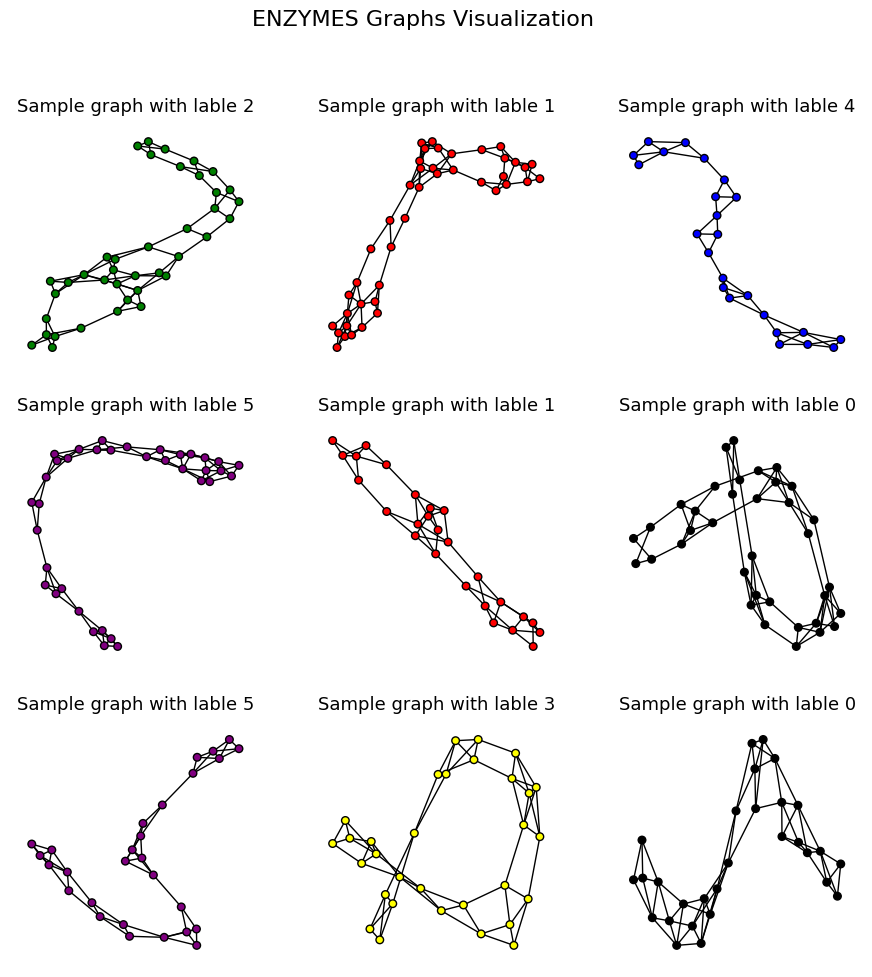

In [16]:
def visualize(dataset):
    color_mapping = {
        0 : 'black',
        1 : 'red',
        2 : 'green',
        3 : 'yellow',
        4 : 'blue',
        5 : 'purple',
    }
    num_graphs_i = 3
    num_graphs_j = 3
    fig, ax = plt.subplots(num_graphs_i, num_graphs_j, figsize=(11, 11))
    fig.suptitle("ENZYMES Graphs Visualization", fontsize=16)
    indices = np.random.choice(np.arange(0, len(dataset)), size=9, replace=False)
    indices = indices.reshape(3, 3)
    for i in range(num_graphs_i):
        for j in range(num_graphs_j):
            index = int(indices[i, j])
            G = dataset[index].G
            label = dataset[index].graph_label.item()
            pos = nx.spring_layout(G, seed=1)
            colors = [color_mapping[label]] * dataset[index].num_nodes
            nodes = nx.draw_networkx_nodes(G, pos=pos, cmap=plt.get_cmap('coolwarm'), \
                node_size=30, ax=ax[(i, j)], node_color=colors)
            nodes.set_edgecolor('black')
            nx.draw_networkx_edges(G, pos=pos, ax=ax[(i, j)])
            ax[(i, j)].set_title("Sample graph with lable {}".format(label), fontsize=13)
            ax[(i, j)].set_axis_off()
    plt.show()
visualize(dataset)

In [ ]:
#GIN model
class GIN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, args):
    super().__init__()

    self.num_layoer = args["num_layers"]

    self.pre_mp = nn.Linear(input_size, hidden_size)
    self.convs = nn.ModuleList()
    self.bns = nn.ModuleList()
    for i in range(self.num_layers):
      layer = Sequential(
          nn.Linear(hidden_size, hidden_size),
          nn.LeakyReLU(),
          nn.Linear(hidden_size, hidden_size),
      )
      self.convs.append(GINConv(layer))
      self.bns.append(nn.BatchNorm1d(hidden_size))
    self.post_mp = Sequential(
        nn.Linear(hidden_size, hidden_size),
        nn.LeakyReLU(),
        nn.Linear(hidden_size, output_size)
    )

  def forward(self, data):
    x, edge_index, batch = data.node_feature, data.edge_index, data.batch
    x = self.pre_mp(x)
    for i in range(len(self.convs)-1):
      x = self.convs[i](x, edge_index)
      x = self.bns[i](x)
      x = F.relu(x)
    x = self.convs[-1](x, edge_index)
    x = pyg_nn.global_add_pool(x, batch)
    x = self.post_mp(x)
    x = F.log_softmax(x, dim=1)
    return x
  def loss(self, pred, label):
    return F.nll_loss(pred, label)

In [ ]:
def train(train_loader, val_loader, test_loader, args, num_node_features, num_classes, device="cpu"):
    model = GIN(num_node_features, args["hidden_size"], num_classes, args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=5e-4)
    best_model = None
    max_val = -1
    for epoch in range(args["epochs"]):
        total_loss = 0
        model.train()
        num_graphs = 0
        for batch in train_loader:
            batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            label = batch.graph_label
            loss = model.loss(pred, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.num_graphs
            num_graphs += batch.num_graphs
        total_loss /= num_graphs
        train_acc = test(train_loader, model, device)
        val_acc = test(val_loader, model, device)
        if val_acc > max_val:
            max_val = val_acc
            best_model = deepcopy(model)
        test_acc = test(test_loader, model, device)
        log = "Epoch {}: Train: {:.4f}, Validation: {:.4f}. Test: {:.4f}, Loss: {:.4f}"
        print(log.format(epoch + 1, train_acc, val_acc, test_acc, total_loss))
    return best_model

def test(loader, model, device='cuda'):
    model.eval()
    correct = 0
    num_graphs = 0
    for batch in loader:
        batch.to(device)
        with torch.no_grad():
            pred = model(batch).max(dim=1)[1]
            label = batch.graph_label
        correct += pred.eq(label).sum().item()
        num_graphs += batch.num_graphs
    return correct / num_graphs

In [ ]:
args = {
    "device" : 'cuda' if torch.cuda.is_available() else 'cpu',
    "hidden_size" : 256,
    "epochs" : 100,
    "lr" : 0.001,
    "num_layers": 3,
    "dataset" : "ENZYMES",
    "batch_size": 32,
}

pyg_dataset = TUDataset('./tmp/enzymes', args["dataset"])
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)
dataset = GraphDataset(graphs, task="graph", minimum_node_per_graph=0)
dataset_train, dataset_val, dataset_test = \
    dataset.split(transductive=False, split_ratio = [0.8, 0.1, 0.1])
num_node_features = dataset.num_node_features
num_classes = dataset.num_graph_labels

train_loader = DataLoader(dataset_train, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"], shuffle=True)
val_loader = DataLoader(dataset_val, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"])
test_loader = DataLoader(dataset_test, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"])

best_model = train(train_loader, val_loader, test_loader, args, num_node_features, num_classes, args["device"])
train_acc = test(train_loader, best_model, args["device"])
val_acc = test(val_loader, best_model, args["device"])
test_acc = test(test_loader, best_model, args["device"])
log = "Best model: Train: {:.4f}, Validation: {:.4f}. Test: {:.4f}"
print(log.format(train_acc, val_acc, test_acc))